In [1]:
# Load environment variables and set up auto-reload
from dotenv import load_dotenv
load_dotenv()

%load_ext autoreload
%autoreload 2

# Multi-Agent Research System

This notebook combines all the previous components into a single system.

Here is our overall research flow:

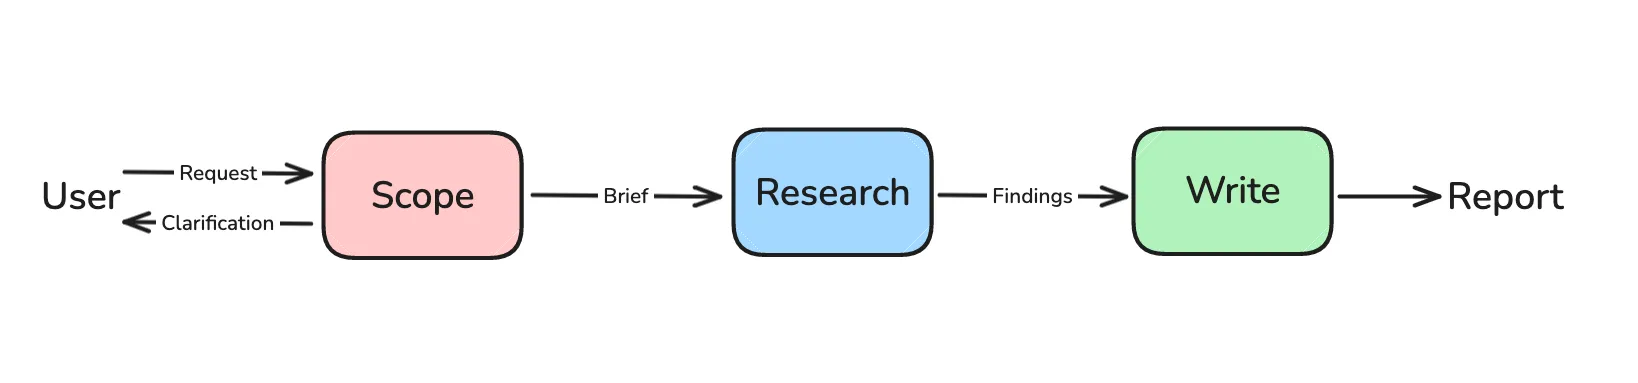

We've built research scoping and multi-agent research in previous notebooks.

Now, we'll add the final report generation step.

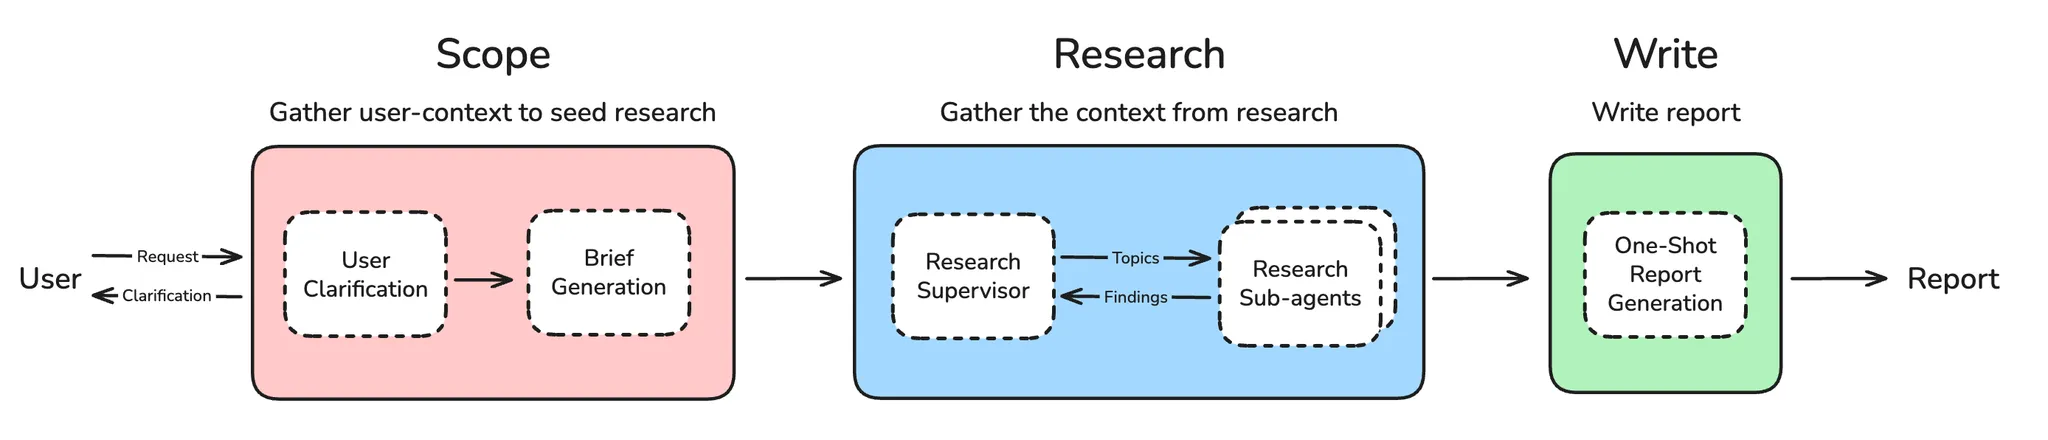

### Agent 

We simply can re-use the components we've already built.

In [2]:
%%writefile ../src/deep_research_from_scratch/research_agent_full.py

"""
Full Multi-Agent Research System

This module integrates all components of the research system:
- User clarification and scoping
- Research brief generation  
- Multi-agent research coordination
- Final report generation

The system orchestrates the complete research workflow from initial user
input through final report delivery.
"""

from langchain_core.messages import HumanMessage
from langgraph.graph import StateGraph, START, END

from deep_research_from_scratch.utils import get_today_str
from deep_research_from_scratch.prompts import final_report_generation_prompt
from deep_research_from_scratch.state_scope import AgentState, AgentInputState
from deep_research_from_scratch.research_agent_scope import clarify_with_user, write_research_brief
from deep_research_from_scratch.multi_agent_supervisor import supervisor_agent

# ===== Config =====

from langchain.chat_models import init_chat_model
writer_model = init_chat_model(model="openai:gpt-4.1", max_tokens=32000) # model="anthropic:claude-sonnet-4-20250514", max_tokens=64000

# ===== FINAL REPORT GENERATION =====

from deep_research_from_scratch.state_scope import AgentState

async def final_report_generation(state: AgentState):
    """
    Final report generation node.
    
    Synthesizes all research findings into a comprehensive final report
    """
    
    notes = state.get("notes", [])
    
    findings = "\n".join(notes)

    final_report_prompt = final_report_generation_prompt.format(
        research_brief=state.get("research_brief", ""),
        findings=findings,
        date=get_today_str()
    )
    
    final_report = await writer_model.ainvoke([HumanMessage(content=final_report_prompt)])
    
    return {
        "final_report": final_report.content, 
        "messages": ["Here is the final report: " + final_report.content],
    }

# ===== GRAPH CONSTRUCTION =====
# Build the overall workflow
deep_researcher_builder = StateGraph(AgentState, input_schema=AgentInputState)

# Add workflow nodes
deep_researcher_builder.add_node("clarify_with_user", clarify_with_user)
deep_researcher_builder.add_node("write_research_brief", write_research_brief)
deep_researcher_builder.add_node("supervisor_subgraph", supervisor_agent)
deep_researcher_builder.add_node("final_report_generation", final_report_generation)

# Add workflow edges
deep_researcher_builder.add_edge(START, "clarify_with_user")
deep_researcher_builder.add_edge("write_research_brief", "supervisor_subgraph")
deep_researcher_builder.add_edge("supervisor_subgraph", "final_report_generation")
deep_researcher_builder.add_edge("final_report_generation", END)

# Compile the full workflow
agent = deep_researcher_builder.compile()

Overwriting ../src/deep_research_from_scratch/research_agent_full.py


In [1]:
# Run the workflow
from utils import format_messages
from IPython.display import Image, display
from langgraph.checkpoint.memory import InMemorySaver
from deep_research_from_scratch.research_agent_full import deep_researcher_builder

checkpointer = InMemorySaver()
full_agent = deep_researcher_builder.compile(checkpointer=checkpointer)
#display(Image(full_agent.get_graph(xray=True).draw_mermaid_png()))

LangGraph has a default recursion limit of 25 steps to prevent infinite loops. For complex research workflows that require iterative rounds of research, this limit needs to be increased. As explained in [LangGraph's troubleshooting guide](https://langchain-ai.github.io/langgraph/troubleshooting/errors/GRAPH_RECURSION_LIMIT/), the recursion limit counts every node execution in the graph. In our multi-agent research system:

- **Single Research Agent**: May take 8-12 steps for tool calls and compression
- **Multi-Agent Supervisor**: Each sub-agent spawned adds additional steps
- **Iterative Research**: Supervisor may conduct multiple rounds of research to fill gaps
- **Full Workflow**: Includes scoping, research brief generation, supervision, and report generation

We set the recursion limit to **50** to accommodate:
- Complex research topics requiring multiple research rounds
- Parallel sub-agent execution
- Deep research with many tool calls
- Complete workflow execution from scoping to final report

This allows the supervisor to conduct iterative rounds of research when initial findings have gaps, ensuring comprehensive coverage of complex research topics.

In [2]:
from langchain_core.messages import HumanMessage
thread = {"configurable": {"thread_id": "1", "recursion_limit": 50}}
result = await full_agent.ainvoke({"messages": [HumanMessage(content="Compare Gemini to OpenAI Deep Research agents.")]}, config=thread)
format_messages(result['messages'])

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ Compare Gemini to OpenAI Deep Research agents.                                                                  │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Could you please specify what aspects you want to compare between Gemini and OpenAI Deep Research agents? For   │
│ example, are you interested in their capabilities, architecture, performance, use cases, or something else?     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

Failed to send compressed multipart ingest: langsmith.utils.LangSmithError: Failed to POST https://api.smith.langchain.com/runs/multipart in LangSmith API. HTTPError('422 Client Error: unknown for url: https://api.smith.langchain.com/runs/multipart', '{"error":"Unprocessable entity: error reading multipart data: multipart: NextPart: EOF"}\n')


In [3]:
result = await full_agent.ainvoke({"messages": [HumanMessage(content="Capabilities and performance of the Deep Research products.")]}, config=thread)

In [4]:
format_messages(result['messages'])

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ Compare Gemini to OpenAI Deep Research agents.                                                                  │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Could you please specify what aspects you want to compare between Gemini and OpenAI Deep Research agents? For   │
│ example, are you interested in their capabilities, architecture, performance, use cases, or something else?     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ Capabilities and performance of the Deep Research products.                                                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ I have sufficient information to proceed with the comparison focusing on the capabilities and performance of    │
│ Gemini and OpenAI Deep Research agents. I will now begin the research process based on these key aspects.       │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ Here is the final report: # Comparative Analysis: Gemini vs. OpenAI Deep Research Agents – Capabilities and     │
│ Performance                                                                                                     │
│                                                                                                                 │
│ ## Introduction                                                                                                 │
│                                                                                                                 │
│ This report delivers a comprehensive, side-by-side comparison of Google's Gemini and OpenAI's Deep Research     │
│ agents based on their current, official documentation and primary sources. The focus is on their functional     │
│ capabilities—including supported features, modalities, and any unique abilities—as well as key performance      │
│ metrics such as speed, accuracy, scalability, and reliability. For clarity and precision, all findings are      │
│ referenced from developers’ official publications and documentation.                                            │
│                                                                                                                 │
│ ---                                                                                                             │
│                                                                                                                 │
│ ## Gemini Research Agents: Capabilities and Performance                                                         │
│                                                                                                                 │
│ ### Functional Capabilities                                                                                     │
│                                                                                                                 │
│ **Multimodal Inputs and Outputs**                                                                               │
│ - Supports processing and understanding of text, images, audio, video, and PDFs natively.                       │
│ - Offers outputs in text, images (through Imagen), audio (multi-language, style-controlled), video (via Veo),   │
│ and music generation.                                                                                           │
│ - Advanced multimodal context handling enables complex, mixed-media inputs for single queries.                  │
│                                                                                                                 │
│ **Context Window and Adaptive Reasoning**                                                                       │
│ - Gemini 2.5 Pro delivers a context window of up to 1 million tokens, with further planned expansions. This     │
│ allows handling of long documents, extensive codebases, and multi-step reasoning without                        │
│ truncation[1][2][5][6].                                                                                         │
│ - Features “adaptive thinking budgets,” giving developers fine-grained control over resource usage versus       │
│ accuracy and response depth[2][4].                                                                              │
│ - Reasoning "through thoughts" allows the model to better structure answers and improve factual accuracy.       │
│                                                                                                                 │
│ **Tool Use and Function Calling**                                                                               │
│ - Supports dynamic real-time function and tool calling, including fetching up-to-date information via Google    │
│ Search integration, code execution, and URL context too

In [5]:
from rich.markdown import Markdown
Markdown(result["final_report"])

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃           Comparative Analysis: Gemini vs. OpenAI Deep Research Agents – Capabilities and Performance           ┃
┗━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┛


                                                   Introduction                                                    

This report delivers a comprehensive, side-by-side comparison of Google's Gemini and OpenAI's Deep Research agents 
based on their current, official documentation and primary sources. The focus is on their functional               
capabilities—including supported features, modalities, and any unique abilities—as well as key performance metrics 
such as speed, accuracy, scalability, and reliability. For clarity and precision, all findings are referenced from 
developers’ official publications and documentation.                                                               

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────

                               Gemini Research Agents: Capabilities and Performance                                

                                              Functional Capabilities                                              

Multimodal Inputs and Outputs                                                                                      

 • Supports processing and understanding of text, images, audio, video, and PDFs natively.                         
 • Offers outputs in text, images (through Imagen), audio (multi-language, style-controlled), video (via Veo), and 
   music generation.                                                                                               
 • Advanced multimodal context handling enables complex, mixed-media inputs for single queries.                    

Context Window and Adaptive Reasoning                                                                              

 • Gemini 2.5 Pro delivers a context window of up to 1 million tokens, with further planned expansions. This allows
   handling of long documents, extensive codebases, and multi-step reasoning without truncation[1][2][5][6].       
 • Features “adaptive thinking budgets,” giving developers fine-grained control over resource usage versus accuracy
   and response depth[2][4].                                                                                       
 • Reasoning "through thoughts" allows the model to better structure answers and improve factual accuracy.         

Tool Use and Function Calling                                                                                      

 • Supports dynamic real-time function and tool calling, including fetching up-to-date information via Google      
   Search integration, code execution, and URL context tools.                                                      
 • Grounding capabilities enhance factuality by referencing live or recent data during the reasoning process.      

Batch and Asynchronous Processing                                                                                  

 • API supports batch processing, asynchronous calls, and session management for efficient high-volume or          
   conversational use cases[1][3].                                                                                 

Developer and User Features                                                                                        

 • Extensive SDK support: Java, Python, TypeScript, JavaScript, Dart, Swift, Kotlin, Java, Unity.                  
 • Integration into Firebase AI Logic enables rapid mobile and web deployments with security features such as API  
   key protection, per-user rate limits, and abuse monitoring[3].                                                  
 • Available through Gemini Advanced, Go

We can see the trace [here](https://smith.langchain.com/public/86ebdc25-4595-4040-be1e-a8e30052786b/r).

### LangGraph Studio

Just as we did before, we can also use LangGraph Studio to visualize the agent. 

The files we wrote with `%%writefile` to `src/deep_research_from_scratch/` during the all the notebooks create the files for our application:

```
deep_research_from_scratch/
├── src/deep_research_from_scratch/
│   ├── state.py          # State definitions
│   ├── scope_research.py # Scoping workflow
│   ├── prompts.py        # Prompt templates
│   └── ...
├── notebooks/            # Development notebooks
├── pyproject.toml        # Dependencies
└── langgraph.json        # LangGraph configuration
```

This agent has been added to the `langgraph.json` file, so you can select `research_agent_full` in the dropdown menu:

```
"research_agent_full": "./src/deep_research_from_scratch/research_agent_full.py:agent"
```

Run the following command to start the studio

```bash
uvx --refresh --from "langgraph-cli[inmem]" --with-editable . --python 3.11 langgraph dev --allow-blocking
```